In [19]:
import pandas as pd
from pathlib import Path
from datetime import datetime
import yaml
import numpy as np
import os


In [3]:
base_path = Path("/Volumes/mrsic_flogel/public/projects/JeKr_130524_Joystick/rotary-encoder/bonsai_joystick_data/")

mouse = "ML_166"
mouse_mod = mouse.replace("_", "")
date = "20251022"
session_path = base_path / mouse / f"bestsessions/ses-001_date-{date}T132111"
print(session_path)

/Volumes/mrsic_flogel/public/projects/JeKr_130524_Joystick/rotary-encoder/bonsai_joystick_data/ML_166/bestsessions/ses-001_date-20251022T132111


In [4]:
lick_folder = session_path / "LickEvents"

# Find all lick CSVs
lick_files = sorted(
    lick_folder.glob("LickEvents*.csv"),
    key=lambda x: datetime.strptime(
        x.stem.replace("LickEvents", ""),  # remove prefix
        "%Y-%m-%dT%H_%M_%S"                 # match filename pattern
    )
)

# Load all lick files
dataframes = [pd.read_csv(f) for f in lick_files]

# Handle both single-file and multi-file cases the same way
if len(dataframes) == 0:
    raise FileNotFoundError("No lick event CSV files found in folder!")



# Concatenate if multiple, or just use the single dataframe
if len(dataframes) > 1:
    concatenated_lick_df = pd.concat(dataframes, ignore_index=True)
    print(f"Concatenated {len(lick_files)} files.")
else:
    concatenated_lick_df = dataframes[0].copy()
    print(f"Only one lick file found: {lick_files[0].name}")


# Keep a copy of the original Seconds column
concatenated_lick_df['Seconds_Original'] = concatenated_lick_df['Seconds']

# Normalize time so it starts at 0 (for internal analysis)
concatenated_lick_df['Seconds'] -= concatenated_lick_df['Seconds'].min()

# Sort by normalized time just to be safe
concatenated_lick_df = concatenated_lick_df.sort_values('Seconds', ignore_index=True)


# Save to same directory with consistent naming
concatenated_csv_path = lick_folder / "Concatenated_Lick.csv"
concatenated_lick_df.to_csv(concatenated_csv_path, index=False)
print(f"Processed lick data saved to {concatenated_csv_path}")

Only one lick file found: LickEvents2025-10-22T14_21_22.csv
Processed lick data saved to /Volumes/mrsic_flogel/public/projects/JeKr_130524_Joystick/rotary-encoder/bonsai_joystick_data/ML_166/bestsessions/ses-001_date-20251022T132111/LickEvents/Concatenated_Lick.csv


In [5]:
session_yaml = session_path / f"Session_{date}_{mouse_mod}.yml"
behaviour_csv = next((session_path / "Joystick").glob("Joystick*.csv"))
harp_events_csv = session_path / "Deserialised" / "AllHarpEvents.csv"
lick_events_csv = next((session_path / "LickEvents").glob("Concatenated_Lick.csv"))
print("Session YAML:      ", session_yaml)
print("Behaviour BIN:     ", behaviour_csv)
print("Harp Events CSV:   ", harp_events_csv)
print("Lick Events CSV:   ", lick_events_csv)

Session YAML:       /Volumes/mrsic_flogel/public/projects/JeKr_130524_Joystick/rotary-encoder/bonsai_joystick_data/ML_166/bestsessions/ses-001_date-20251022T132111/Session_20251022_ML166.yml
Behaviour BIN:      /Volumes/mrsic_flogel/public/projects/JeKr_130524_Joystick/rotary-encoder/bonsai_joystick_data/ML_166/bestsessions/ses-001_date-20251022T132111/Joystick/Joystick2025-10-22T14_21_14.csv
Harp Events CSV:    /Volumes/mrsic_flogel/public/projects/JeKr_130524_Joystick/rotary-encoder/bonsai_joystick_data/ML_166/bestsessions/ses-001_date-20251022T132111/Deserialised/AllHarpEvents.csv
Lick Events CSV:    /Volumes/mrsic_flogel/public/projects/JeKr_130524_Joystick/rotary-encoder/bonsai_joystick_data/ML_166/bestsessions/ses-001_date-20251022T132111/LickEvents/Concatenated_Lick.csv


In [6]:
with open(session_yaml, "r") as f:
    session_metadata = yaml.safe_load(f)
print("Session Metadata:  ", session_metadata)

Session Metadata:   {'subjectID': 'ML166', 'sessionID': '001', 'audioCueActive': True, 'numberOfTrials': 100, 'ITISeconds': 0.1, 'rewardProbability': 1.0, 'landmarks': {'mapping': {'A': '1', 'B': '2', 'C': '3', 'D': '4'}, 'jitter': 1.8, 'dwellSeconds': 0.1}, 'paths': {'rigConfigPath': './Schemas/RigConfiguration_Arducam.yml', 'scaraConfigPath': './Schemas/Scara.yml', 'landmarksPath': './Schemas/newgrid3b-2594.yml', 'audioCuePath': './assets/audio/tone.wav', 'loggingPath': 'D:\\JoystickABCDLocalData'}, 'flags': {'excludeJoystickLog': False, 'automaticReward': True, 'downsampleEncodersLog': False, 'excludeAnalogData': False}}


In [7]:
harp_columns = ["OutputSet_Time", "OutputSet_DO2", "TimestampSeconds_TimestampSeconds"]
harp_events = pd.read_csv(harp_events_csv, usecols=harp_columns)

behaviour_columns = ["Seconds", "Value.JoystickPositionX", "Value.JoystickPositionY"]
behaviour_df = pd.read_csv(behaviour_csv, usecols=behaviour_columns)

lick_columns = ["Seconds", "Value.LickDetected", "Seconds_Original"]
lick_events_df = pd.read_csv(lick_events_csv, usecols=lick_columns)

/var/folders/xx/n595cmhn0ps14g71shgj79140000gn/T/ipykernel_36599/1728710681.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  harp_events = pd.read_csv(harp_events_csv, usecols=harp_columns)


In [31]:
harp_events['OutputSet_Time'].values

array([3.84398408e+09, 3.84398413e+09, 3.84398425e+09, ...,
                  nan,            nan,            nan])

In [8]:
sess_reward_data = harp_events.set_index('OutputSet_Time')
sess_lick_data = lick_events_df.set_index('Seconds_Original')
sess_joystick_data = behaviour_df.set_index('Seconds')

sess_reward_data = sess_reward_data[~sess_reward_data.index.duplicated(keep='first')]
sess_lick_data = sess_lick_data[~sess_lick_data.index.duplicated(keep='first')]
sess_joystick_data = sess_joystick_data[~sess_joystick_data.index.duplicated(keep='first')]

sess_data = {
        'Rewards': pd.Series(sess_reward_data['OutputSet_DO2'], index=sess_reward_data.index),
        'Licks': pd.Series(sess_lick_data['Value.LickDetected'], index=sess_lick_data.index),
        'JoystickX': pd.Series(sess_joystick_data['Value.JoystickPositionX'], index=sess_joystick_data.index),
        'JoystickY': pd.Series(sess_joystick_data['Value.JoystickPositionY'], index=sess_joystick_data.index),
    }
#combine indices
all_ix = sess_reward_data.index.union(sess_lick_data.index).union(sess_joystick_data.index)
#take only unique indices
all_ix = all_ix.unique()

sess_dataframe = pd.DataFrame(sess_data, index=all_ix)
sess_dataframe['JoystickX'] = sess_dataframe['JoystickX'].interpolate()
sess_dataframe['JoystickY'] = sess_dataframe['JoystickY'].interpolate()
with pd.option_context("future.no_silent_downcasting", True):
    sess_dataframe['Licks'] = sess_dataframe['Licks'].fillna(False).astype(bool) 
    sess_dataframe['Rewards'] = sess_dataframe['Rewards'].fillna(False).astype(bool)

In [9]:
with pd.option_context("future.no_silent_downcasting", True):
    sess_dataframe['Licks'] = sess_dataframe['Licks'].fillna(False).astype(bool) 
    sess_dataframe['Rewards'] = sess_dataframe['Rewards'].fillna(False).astype(bool)

In [ ]:
# Load the grid schema
grid_path = os.path.join(base_path, "joystick_grid_ymls")
landmarks_file = session_metadata['paths']['landmarksPath'].split("/")[-1]

with open(os.path.join(grid_path, landmarks_file), "r") as f:
    landmarks_data = yaml.safe_load(f)

landmarks_data['positions']
a_mapping = int(session_metadata['landmarks']['mapping']['A'])
a_position = [0, 0]
a_position[0] = landmarks_data['positions'][a_mapping]['x']
a_position[1] = landmarks_data['positions'][a_mapping]['y']
b_mapping = int(session_metadata['landmarks']['mapping']['B'])
b_position = [0, 0]
b_position[0] = landmarks_data['positions'][b_mapping]['x']
b_position[1] = landmarks_data['positions'][b_mapping]['y']
c_mapping = int(session_metadata['landmarks']['mapping']['C'])
c_position = [0, 0]
c_position[0] = landmarks_data['positions'][c_mapping]['x']
c_position[1] = landmarks_data['positions'][c_mapping]['y']
d_mapping = int(session_metadata['landmarks']['mapping']['D'])
d_position = [0, 0]
d_position[0] = landmarks_data['positions'][d_mapping]['x']
d_position[1] = landmarks_data['positions'][d_mapping]['y']

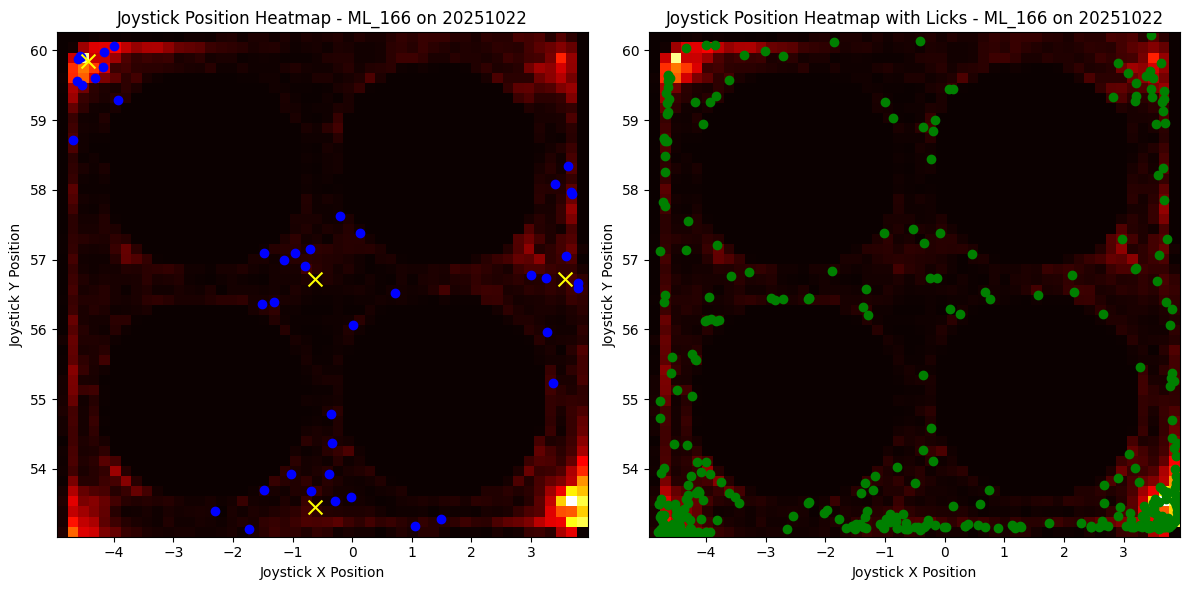

In [46]:
#plot x and y position as heatmap and overlay reward positions
import matplotlib.pyplot as plt
reward_positions = sess_dataframe[sess_dataframe['Rewards'] == True][['JoystickX', 'JoystickY']]
lick_positions = sess_dataframe[sess_dataframe['Licks'] == True][['JoystickX', 'JoystickY']]

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist2d(sess_dataframe['JoystickX'], sess_dataframe['JoystickY'], bins=50, cmap='hot')
plt.scatter(reward_positions['JoystickX'], reward_positions['JoystickY'], c='blue', label='Reward Given')
plt.scatter(a_position[0], a_position[1], c='yellow', marker='x', s=100, label='Landmark A')
plt.scatter(b_position[0], b_position[1], c='yellow', marker='x', s=100, label='Landmark B')
plt.scatter(c_position[0], c_position[1], c='yellow', marker='x', s=100, label='Landmark C')
plt.scatter(d_position[0], d_position[1], c='yellow', marker='x', s=100, label='Landmark D')
plt.title(f"Joystick Position Heatmap - {mouse} on {date}")
plt.xlabel("Joystick X Position")
plt.ylabel("Joystick Y Position")
plt.subplot(1,2,2)
plt.hist2d(sess_dataframe['JoystickX'], sess_dataframe['JoystickY'], bins=50, cmap='hot')
plt.scatter(lick_positions['JoystickX'], lick_positions['JoystickY'], c='green', label='Lick Detected')
plt.title(f"Joystick Position Heatmap with Licks - {mouse} on {date}")
plt.xlabel("Joystick X Position")
plt.ylabel("Joystick Y Position")
plt.tight_layout()
plt.show()

In [47]:
seq_length = 4
num_rewards = sess_dataframe['Rewards'].sum()
print(f"Number of rewards in session: {num_rewards}")

#create a variable with the length of num_rewards that repeats every seq_length times
reward_seq = np.tile(np.arange(seq_length), num_rewards // seq_length + 1)[:num_rewards]

Number of rewards in session: 45


In [48]:
reward_seq

array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1,
       2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
       0])

In [68]:
reward_positions.iloc[3]

JoystickX     3.268744
JoystickY    55.964256
Name: 3843984248.685504, dtype: float64

In [67]:
#get the index of the 4th row in reward_positions
start = reward_positions.iloc[3].index
end = reward_positions.iloc[4].index
#extract joystick positions between start and end
joystick_segment_x = sess_dataframe.loc[start, 'JoystickX']
joystick_segment_y = sess_dataframe.loc[start:end, 'JoystickY']

KeyError: "None of [Index(['JoystickX', 'JoystickY'], dtype='object')] are in the [index]"

In [54]:
#goal is to calculate shortest path per segment and then trial by trial taken path -> relative path length per 
distance_ab = np.abs(np.array(a_position)[0] - np.array(b_position)[0]) + np.abs(np.array(a_position)[1] - np.array(b_position)[1])
distance_bc = np.abs(np.array(b_position)[0] - np.array(c_position)[0]) + np.abs(np.array(b_position)[1] - np.array(c_position)[1])
distance_cd = np.abs(np.array(c_position)[0] - np.array(d_position)[0]) + np.abs(np.array(c_position)[1] - np.array(d_position)[1])
distance_da = np.abs(np.array(d_position)[0] - np.array(a_position)[0]) + np.abs(np.array(d_position)[1] - np.array(a_position)[1])

In [ ]:
#segment joystick positions inbetween reward events


7.470108102416993